<a href="https://colab.research.google.com/github/Doson24/Wildberries_price/blob/main/Wildberries_price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Решает задачу оперативной оценки текущей стоимости товаров Wildberris по отношении к его минимальной стоимости      

Результат в ввиде файла Excel сохранный в google drive    

Признаки: 
*   'Имя товара'
*   'Бренд'
*   'Текущая Цена со скидкой'
*   'Цена без скидки'
*    "Мин цена"
*    "Дата мин цены"
*    'Скидка'
*    'Рейтинг'
*   'Кол-во отзывов'
*   'Url товара'

Для добавления товара в список отслеживания вставте id товара в переменную list_id

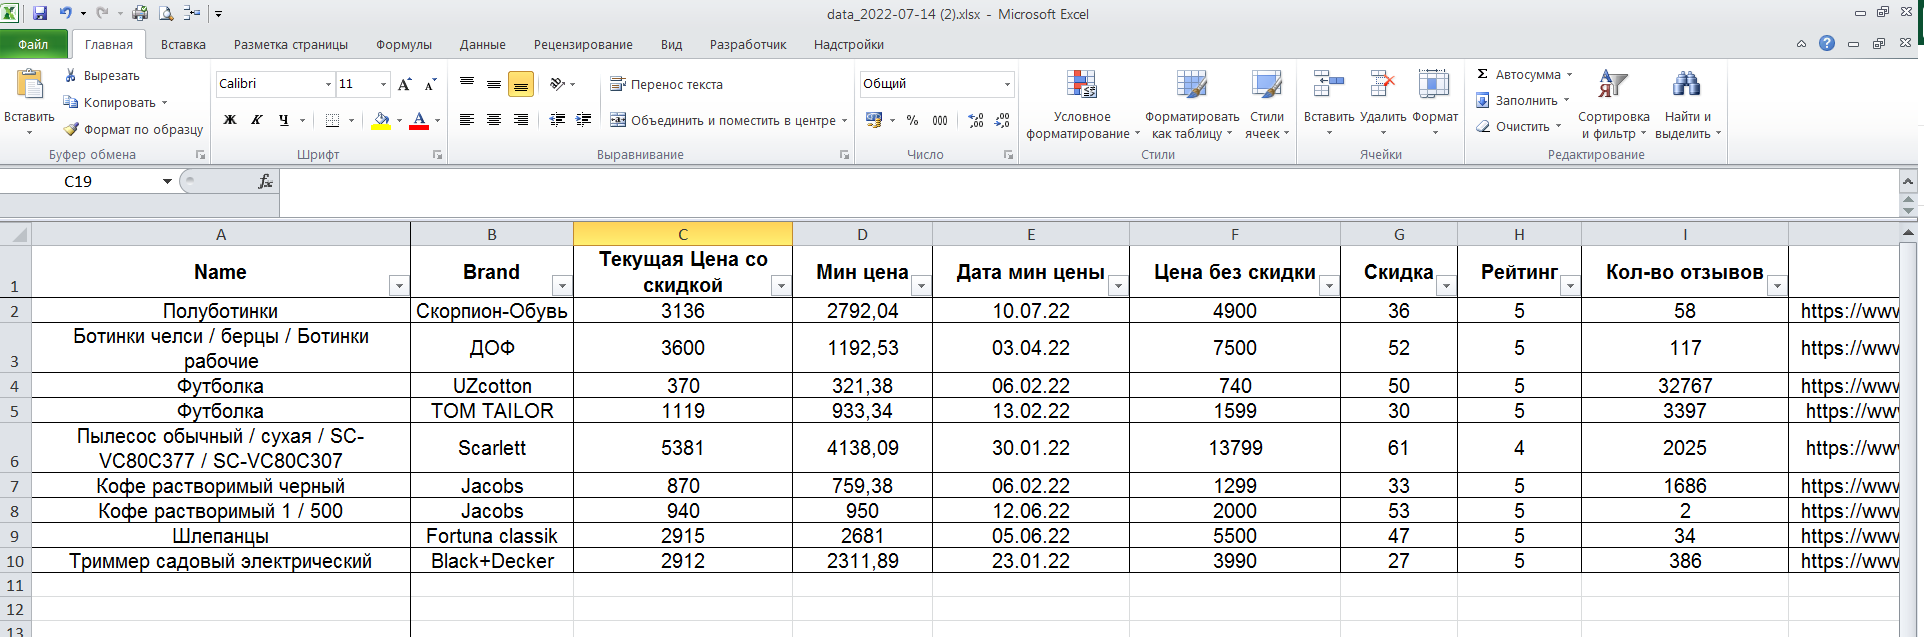

      
В дальнейшем будет использоваться для поиска товара c минимальной ценой по всему ассортименту Wildberries и сравнением с другими маркетплейсами типа OZON


### Пример работа через Selenium

In [13]:
!pip install selenium
!apt-get update 
!apt install chromium-chromedriver
!pip install styleframe

from selenium import webdriver
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
driver = webdriver.Chrome('chromedriver',chrome_options=chrome_options)
from selenium.webdriver.common.by import By

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:3 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubunt

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning:use options instead of chrome_options


In [14]:
driver.get('https://www.wildberries.ru/catalog/6887893/detail.aspx?targetUrl=XS&size=24017851')
driver.set_window_size(1920,1080)


In [25]:
import time
time.sleep(3)
driver.save_screenshot('save.png')

True

In [26]:
product_name = driver.find_element(By.CLASS_NAME, 'product-page__header').text
review = driver.find_element(By.CLASS_NAME, 'product-review__count-review').text
star = driver.find_element(By.CLASS_NAME, 'product-review__rating').text
order_quantity = driver.find_element(By.CLASS_NAME, 'product-order-quantity').text
final_price = driver.find_element(By.CLASS_NAME, 'price-block__content')

###Извлечение данных через request

In [27]:
import requests
import pandas as pd
import datetime as dt
from openpyxl import Workbook

In [28]:
f'https://card.wb.ru/cards/detail?spp=0&\
  regions=68,64,83,4,38,80,33,70,82,86,75,30,69,22,66,31,40,1,48,71&\
  pricemarginCoeff=1.0&\
  reg=0&\
  appType=1&\
  emp=0&\
  locale=ru&\
  lang=ru&\
  curr=rub&\
  couponsGeo=12,3,18,15,21&\
  dest=-1029256,-102269,-2162196,-1257786&\
  nm={id}'

'https://card.wb.ru/cards/detail?spp=0&  regions=68,64,83,4,38,80,33,70,82,86,75,30,69,22,66,31,40,1,48,71&  pricemarginCoeff=1.0&  reg=0&  appType=1&  emp=0&  locale=ru&  lang=ru&  curr=rub&  couponsGeo=12,3,18,15,21&  dest=-1029256,-102269,-2162196,-1257786&  nm=82659948'

In [29]:
list_id = [6887893, 12801489, 14425740, 83890504, 7598615, 13282010, 12515365, 57906046, 82659948]

# url = 'https://www.wildberries.ru/catalog/6887893/detail.aspx?targetUrl=XS'
# id = 6887893
names, brands, priceus, sales, salePriceUs, ratings, feedbacks, min_price_historys, min_date_price_historys, urls =[], [], [], [], [], [], [], [], [], []

for id in list_id:
  url_info = f'https://card.wb.ru/cards/detail?spp=0&regions=68,64,83,4,38,80,33,70,82,86,75,30,69,22,66,31,40,1,48,71&pricemarginCoeff=1.0&reg=0&appType=1&emp=0&locale=ru&lang=ru&curr=rub&couponsGeo=12,3,18,15,21&dest=-1029256,-102269,-2162196,-1257786&nm={id}'

  data = requests.get(url_info).json()
  path_js = data['data']['products'][0]

  names.append(path_js['name'])
  brands.append(path_js['brand'])
  priceus.append(path_js['priceU'] / 100)
  sales.append(path_js['sale'])
  salePriceUs.append(path_js['salePriceU'] / 100)
  ratings.append(path_js['rating'])
  feedbacks.append(path_js['feedbacks'])

  url_h = f'https://wbx-content-v2.wbstatic.net/price-history/{id}.json'
  # headers = {'referer': f'https://www.wildberries.ru/catalog/{id}/detail.aspx?targetUrl=XS&size=24017853'}
  if requests.get(url_h).status_code == 200:
      data_h = requests.get(url_h).json()
      # for i in data_h: 
      date = [dt.date.fromtimestamp(data_h[i]['dt']) for i in range(len(data_h))]
      price = [data_h[i]['price']['RUB'] / 100 for i in range(len(data_h))]
      price_history = pd.DataFrame({
          "Дата": date,
          "Цена": price
      })
  else: price_history = 'нет в наличии'

  min_price_historys.append(price_history.loc[price_history['Цена'] == price_history['Цена'].min()].values.tolist()[0][1])
  min_date_price_historys.append(price_history.loc[price_history['Цена'] == price_history['Цена'].min()].values.tolist()[0][0])
  urls.append(f'https://www.wildberries.ru/catalog/{id}/detail.aspx?targetUrl=XS')

In [30]:
out_data = pd.DataFrame({
    'Name': names,
    'Brand': brands,
    'Текущая Цена со скидкой': salePriceUs,  
    "Мин цена": min_price_historys,
    "Дата мин цены": min_date_price_historys, 
    'Цена без скидки': priceus,
    'Скидка': sales, 
    'Рейтинг': ratings, 
    'Кол-во отзывов': feedbacks,
    'Url товара': urls
})

In [31]:
out_data.sort_values(['Brand', 'Кол-во отзывов'], ascending=False, inplace=True)

####Сохранение в Excel, изменние стиля

In [32]:
from styleframe import StyleFrame
import datetime
 

excel_writer = StyleFrame.ExcelWriter(f'data_{datetime.date.today()}.xlsx')
sf = StyleFrame(out_data)


# sf.set_row_height_dict({index + 2: (max(sf.data_df[column].astype(str).str.count('\n') for column in sf.data_df.columns) + sf.A_FACTOR) * sf.P_FACTOR * 2
#                         for index, _ enumerate(out_data.index)})

sf.to_excel(
    excel_writer=excel_writer, 
    best_fit=list(out_data.columns),
    columns_and_rows_to_freeze='B2', 
    row_to_add_filters=0
)

excel_writer.save()
# out_data.to_excel('test.xlsx')


#### Сохранение на Гугл драйв


In [33]:
def save_google_drive():
    from google.oauth2 import service_account
    from googleapiclient.http import MediaIoBaseDownload,MediaFileUpload
    from googleapiclient.discovery import build
    # pp = pprint.PrettyPrinter(indent=4)
    SCOPES = ['https://www.googleapis.com/auth/drive']
    SERVICE_ACCOUNT_FILE = '/content/driveproject-324903-d4a60ac0fd0b.json'
    credentials = service_account.Credentials.from_service_account_file(
            SERVICE_ACCOUNT_FILE, scopes=SCOPES)

    service = build('drive', 'v3', credentials=credentials)

    results = service.files().list(pageSize=10,
                               fields="nextPageToken, files(id, name, mimeType)").execute()
    # pp.pprint(results)
    folder_id = '1zrNZFS70ctSYYhSd4BtO6HulY6apRNX_'
    name = f'data_{datetime.date.today()}.csv'
    file_path = f'/content/data_{datetime.date.today()}.xlsx'
    file_metadata = {
                    'name': name,
                    'parents': [folder_id]
                }
    media = MediaFileUpload(file_path, resumable=True)
    r = service.files().create(body=file_metadata, media_body=media, fields='id').execute()
    # pp.pprint(r)

In [34]:
save_google_drive()

FileNotFoundError: ignored